_by Max Schröder$^{1,2}$, Susanne Staehlke$^3$, J. Barbara Nebe$^3$, and Frank Krüger$^1$_

$^1$ Institute of Communications Engineering, University of Rostock, Rostock <br>
$^2$ University Library, University of Rostock, Rostock <br>
$^3$ Department of Cell Biology, Rostock University Medical Center, Rostock

**Abstract**: 
The following Jupyter notebook encodes parts of the data analysis that was done for the above mentioned article <i data-cite="Staehlke2018">(Staehlke et al. 2018)</i>.
The idea of this notebook is to illustrate how Jupyter notebooks can be employed to make data analyses reproducible and interactive.
To this end, the notebook first load and inspect the data visually, then defines the main functions to re-create figures and tables from the original article.
Finally interactive notebook elements will be employed to allow further data exploration.

# Introduction

The main purpose of the experiment and the data analysis at hand is to investigate the mechanisms of cells on a material surface in the cell-biosystem interactions.
To this end, the influence of external factors of **material coatings** to **morphological** and **structural** characteristics of the surrounding tissue are explored in order to establish a design for new biofunctional implants, and thus improve the integration in the tissue. 

Cells react directly or indirectly to their environment, such as physico-chemical properties of implant surfaces. 
It is, however, not yet fully understood how these external signals and stimuli are transmitted into the cell and are finally translated in a cell-specific way. 
A further step to understand the specific response of cells at the molecular level is the investigation of intracellular signaling cascades. 
An important “second messenger” in the cells are the calcium ions ($Ca^{2+}$) which regulate important cell signaling pathways. 
One option to analyze the mobilization of intracellular $Ca^{2+}$ is Ca-imaging <i data-cite="Staehlke2015">(Staehlke et al. 2015)</i>. 

Briefly, the vital cells were stained with a calcium indicator (Fluo-3 acetoxymethyl ester). 
The Fluo-3 dye combined with the intracellular $Ca^{2+}$ ions induces fluorescence that can be detected via confocal laser scanning microscopy (LSM780, Carl Zeiss). 
This fluorescence profile of emitted light upon laser excitation (488 nm) is then time-dependently recorded by 240 cycles á 2 s (time 480 s) (software Zenblack, Carl Zeiss). 
To activate the release of intracellular $Ca^{2+}$ (from intracellular stores, the endoplasmic reticulum), adenosine 5'-triphosphate (ATP) was added even after the 90th cycle. 

Previous cell biological studies have shown an improvement in initial cell attachment, spreading, and regulation of cells’ physiology due to a chemically modified surface - a nanolayer of plasma polymerized allylamine with positive charge carriers (PPAAm) <i data-cite="Rebl2016,Nebe2019">(Rebl et al. 2016, Nebe et al. 2019)</i>. 
In our reconstruction analysis, $Ca^{2+}$ mobilization measurements were performed in human bone cells (osteoblasts) (i) for the cell line MG-63 <i data-cite="Staehlke2018a">(Staehlke et al. 2018a)</i> on titanium (Ti) substrates with PPAAm  - Ti + PPAAm and bioactive collagen type-I - Ti + Col, bare Ti substrates - Ti; tissue culture plastic - IBIDI), as well as (ii) to establish the results for primary osteoblasts (HOB) compared to MG-63 cells on Ti+PPAAm vs. bare Ti. The study demonstrated that the positively charged PPAAm layer resulted in an improved global intracellular $Ca^{2+}$ mobilization after adenosine 5'-triphosphate (ATP) stimulus in human osteoblasts <i data-cite="Staehlke2018a">(Staehlke et al. 2018a)</i>.


Using the modular analysis-software (Zen blue, Zeiss) with the function “Mean ROI”, a region of interest (ROI, same size) was placed in the cell, and the fluorescence intensity of the $Ca^{2+}$ signal was analyzed in 10 cells. 
The measured fluorescence intensity is exported as tabular data to a Microsoft Excel file.
The original publication used a manual process to ETL (extract, transform, load), which is time consuming and error prone, and analyzed the data with a graphical tool for data analysis.
While these tools allow the effective and efficient statistical data analysis, they are generally not traceable as the analysis is mainly driven by point and click interaction.

The objective of this document is to reproduce parts of the data analysis of the original publication <i data-cite="Staehlke2018">(Staehlke et al. 2018)</i>  in order to illustrate possible advantages with respect to traceability and reproduciblity.
To this end, the Python programming language is used to resemble the original data analysis.


# Preparation of the computational environment

The following code cell loads necessary packages that extend the functionality of the core Python 3 environment.
The __xlrd__ package provides functionality in order to load the proprietary file format of Microsoft Excel.
It is used in combination with the __pandas__ package that provides the data type _DataFrame_ which is used for handling the data.
The __numpy__ and __scipy__ packages are used for the statistical analysis.
The __matplotlib__ package is used in order to plot the data.

In [1]:
%matplotlib inline

import xlrd
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

Beside loading neccessary packages, it is of interest to document the runtime environment including the version of all loaded packages and the active system configuration. This is done in the following by employing the [watermark extension](https://github.com/rasbt/watermark).

In [2]:
%load_ext watermark
%watermark -i -v -h -m -iv -g -r -w

matplotlib 3.1.1
pandas     0.25.1
scipy      1.3.1
xlrd       1.2.0
numpy      1.17.2
2019-11-19T14:41:35+01:00

CPython 3.7.3
IPython 7.8.0

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.0-6-amd64
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit
host name  : jupyter
Git hash   : 2bf7dd2fb63a829cb633aabaff69247a4aca9a07
Git repo   : git@gitlab.elaine.uni-rostock.de:INF/paper/P191115-Jupyter-MS.git
watermark 2.0.1


# Define Helper Functions

## Load Excel Files
As the data is distributed over different files, in the following we define functions to read a list of files and merge their content appropriately. 
For each Excel file in the list, the data is loaded, the first row is omitted and all columns that contain either the word `Time` or the word `IntensityMean` in the column name are selected.
Then the names are replaced and the data are merged by row index.

In [3]:
def read_measurement_files(filenames: list, type_name: str):
    data = None
    for idx, file in enumerate(filenames):
        df = pd.read_excel(file, skiprows=[1])
        # select only columns with Time and IntensityMean
        df = df[df.columns[df.columns.to_series().str.contains('Time|IntensityMean')]]
        df.columns = ['Time'] + ['R%i_%i' % (colidx, idx+1) for colidx in range(1, len(df.columns))]
        data = df if idx == 0 else pd.concat([data, df.loc[:, df.columns != 'Time']], axis=1)
    data['Type'] = type_name
    return data

## Summarize the Measurement Data

In order to provide a generalized statement for each cycle, for each row, the data is summarized by mean value and the standard error of the mean.

In [4]:
def summarize_measurement(data: pd.DataFrame):
    selection = data.drop(['Time','Type'], axis=1)
    data['mean'] = selection.mean(axis=1)
    data['sem'] = selection.sem(axis=1)
    return(data)

## Plot Measurement Data

To plot the data, first it is transformed from wide (different measurements of the same variable are represented by columns) to long format, where all measurement data, independent from the repetition is represented in the same column. 
For both the original data and the row wise summary the data is then grouped by the surface type (variable `Type`)  and plotted. 
For the row wise summary the mean is provided by a line and the standard error of the mean by a colored region around the mean.

In [5]:
def plot_measurement_all(data: pd.DataFrame):
    selection = data.drop(['Type','mean','sem'], axis=1)
    twothirds = selection.drop(['Time'], axis=1).max().max() * 2/3
    selection.plot.line(x='Time', legend=False, marker='.')
    plt.vlines(3, ymin = 0, ymax = twothirds, linestyles='dotted')
    plt.text(x=3, y=twothirds+5, s='ATP')
    plt.xlabel('Time [min]')
    plt.ylabel('Mean fluoresence intensity')

def plot_measurement_summary(data: pd.DataFrame):
    selection = data[['Time', 'Type','mean','sem']]
    maxMean = selection['mean'].max()
    
    for t in selection.Type.unique():
        sel = selection[selection.Type == t]
        plt.plot(sel['Time'], sel['mean'])
        plt.fill_between(sel['Time'], sel['mean']-sel['sem'], sel['mean']+sel['sem'],alpha=0.1)
    plt.vlines(3, ymin = 0, ymax = maxMean, linestyles='dotted')
    plt.text(x=3, y=maxMean+5, s='ATP')
    plt.xlabel('Time [min]')
    plt.ylabel('Mean fluoresence intensity')
    plt.legend(title='Type', labels=selection.Type.unique())

# Load and Inspect Measurement Data

Four different conditions for the surface have been investigated:
 * Bare titanium substrate (`Ti`)
 * Titanium substrate modified by amino functionalization with plasma polymerized allylamine (`Ti+PPAAm`)
 * Titanium substrate modified by immobilization of a bioactive collagen type-I layer (`Ti+Col`)
 * Standard tissue culture plastic (`IBIDI`)

For each of the conditions, three different samples were taken. 
For each of the samples, the global $Ca^{2+}$ fluorescence signal from individual cells was measured and recorded by use of the ZEN software (ZEISS efficient Navigation, ZEN 2011 SP4, black edition).
This was done for 240 cycles with a duration of 2s per cycle.
After the 90th cycle ATP was added in order to stimulate the cells' endoplasmic reticula.
For each such time series, at least ten cells were observed for the entire time span and the mean fluorescence intensity was determined.
This procedure yielded in three data frames with 240 measurements per cell and at least ten measurements per cycle.

The data was then converted into a table structure and stored in three different Excel files per condition.
In the following the filenames are provided accordingly.

In [6]:
ppaam_fn = ["../_Data/Fig. 5_MG63_19.07.2016_PPAAm_n1.xlsx",
            "../_Data/Fig. 5_MG63_19.07.2016_PPAAm_n2.xlsx",
            "../_Data/Fig. 5_MG63_19.07.2016_PPAAm_n3.xlsx"]

ti_fn = ["../_Data/Fig. 5_MG63_19.07.2016_Ti_n1.xlsx",
         "../_Data/Fig. 5_MG63_19.07.2016_Ti_n2.xlsx",
         "../_Data/Fig. 5_MG63_19.07.2016_Ti_n3.xlsx"]

ticol_fn = ["../_Data/Fig. 5_MG63_Col_n1.xlsx",
            "../_Data/Fig. 5_MG63_Col_n2.xlsx",
            "../_Data/Fig. 5_MG63_Col_n3.xlsx"]

ibidi_fn = ["../_Data/Fig. 5_MG63_IBIDI_n1.xlsx",
            "../_Data/Fig. 5_MG63_IBIDI_n2.xlsx",
            "../_Data/Fig. 5_MG63_IBIDI_n3.xlsx"]

## Titanium surface

Load the base measurement data for the Ti surface and provide a preview to the first rows of the dataset.

In [7]:
ti = read_measurement_files(ti_fn, 'Ti')
ti_summary = summarize_measurement(ti)
ti.head(n=6)

,Time,R1_1,R2_1,R3_1,R4_1,R5_1,R6_1,R7_1,R8_1,R9_1,...,R4_3,R5_3,R6_3,R7_3,R8_3,R9_3,R10_3,Type,mean,sem
0,0.000000,46.724508,41.204120,61.086799,49.620561,46.633628,56.501838,53.880435,47.160221,31.318426,...,28.382138,64.847222,120.590909,63.167647,92.656695,66.343658,92.756757,Ti,57.753450,4.062095
1,0.033333,47.425760,41.162921,59.473779,49.358879,46.361062,55.518382,52.876812,46.856354,31.128801,...,27.253294,64.269444,120.114370,62.911765,91.414530,65.308260,92.302987,Ti,56.870557,3.974362
2,0.066683,47.516995,40.814607,58.828210,48.740187,47.511504,55.996324,51.094203,47.075506,31.187835,...,27.412884,62.806944,119.005865,62.054412,87.141026,63.859882,91.891892,Ti,55.962700,3.877056
3,0.100050,46.649374,41.205993,57.909584,48.957009,47.660177,55.799632,50.663043,47.572744,30.899821,...,27.120059,61.900000,117.187683,61.683824,85.226496,63.205015,90.017070,Ti,55.249254,3.781677
4,0.133367,46.973166,41.400749,56.844485,48.800000,46.851327,54.345588,50.378623,47.430939,30.572451,...,26.459736,60.809722,115.790323,62.110294,82.109687,62.874631,89.513514,Ti,54.454818,3.691801
5,0.166733,46.069767,40.949438,56.065099,49.345794,46.723894,55.163603,49.932971,47.889503,29.568873,...,26.931186,59.987500,115.285924,61.457353,81.566952,63.485251,90.816501,Ti,53.805348,3.660207


Plot the individual time series for the Ti surface. The addition of ATP is marked by a dotted line after 90 cycles.

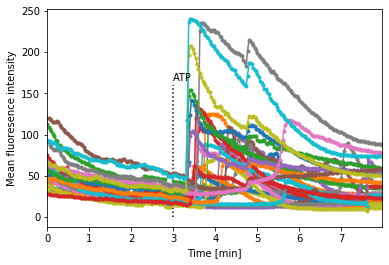

In [8]:
plot_measurement_all(ti)

Plot the mean and the standard error of the mean for the time series of the Ti surface. Again, the dotted line represents the time of ATP addition.
From the plot it can be observed that after providing ATP, the mean fluorescence in the observed cells increases.
As the actual amount of the increase varies for the different cells, it is of interest to investigate the mean values of all cells.

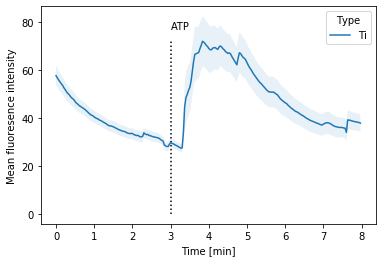

In [9]:
plot_measurement_summary(ti_summary)

Again, it can be observed that the mean fluorescence increases shortly after providing the ATP. The amount of actual increase differs as can be seen from the standard error of the mean in the time between three and five minutes.
After 5 minutes, the mean increase of the intensity decreases steadily.

## Plasma polymerized allylamine modified Ti surface
When considering the Ti+PPAAm modified surface, a similar, but more distinct increase is expected.

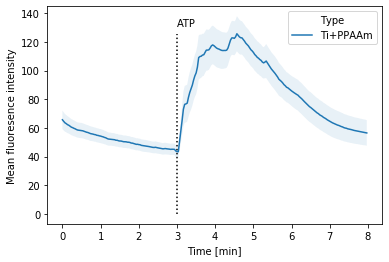

In [10]:
ppaam = read_measurement_files(ppaam_fn, 'Ti+PPAAm')
ppaam_summary = summarize_measurement(ppaam)

plot_measurement_summary(ppaam_summary)

From the above plot, it can be observed that the increase of the mean fluorescence intensity increases directly after providing the ATP. In addition the actual amount of increase is much higher than for the bare Ti surface.

## Comparing the different conditions

By comparing the different conditions, the difference in the reaction of the cells on the differently modified surfaces is more distinct. 

To this end, we first load the both remaining datasets and create a new data frame from all four measurement tables. 
In the direct comparison, it can be observed that the cells on all surfaces, except for the bare Ti surface, directly react on the ATP addition.
Also, it can be observed that the reaction of the both, `Ti+PPAAm` and `Ti+Col` are more intensive.

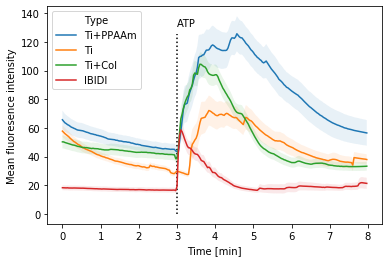

In [11]:
# read measurement data for Ti collagen surface
ticol = read_measurement_files(ticol_fn, 'Ti+Col')
ticol_summary = summarize_measurement(ticol)

# read measurement data for the tissue culture plastic
ibidi = read_measurement_files(ibidi_fn, 'IBIDI')
ibidi_summary = summarize_measurement(ibidi)

# merge all measurements to the same table
all_data = pd.concat([
    ppaam_summary[['Time', 'Type', 'mean', 'sem']],
    ti_summary[['Time', 'Type', 'mean', 'sem']],
    ticol_summary[['Time', 'Type', 'mean', 'sem']],
    ibidi_summary[['Time', 'Type', 'mean', 'sem']]
], ignore_index=True)
plot_measurement_summary(all_data)

In order to determine the difference of the mean fluorescence intensity of the different conditions before and after ATP provision, in the following a table is created that provides the mean and the standard error of the mean for all measurements. 
First, the raw data for all conditions is loaded, transformed from wide (one column per cell time series) to long format (all measurement in one column). 
The variable `Region` is then omitted and the data is grouped into data __before__ and __after__ ATP provision (variable `CaSignal`).
Then, the mean and standard error of the mean is calculated for each combination of surface (variable `Type`) and `CaSignal` and transformed into a table.

From the table, it can be observed that, indeed, the mean fluorescence intensity when using Ti+PPAAm surface increased much.

In [12]:
summary_data = pd.concat([
    ppaam.drop(['mean', 'sem'], axis=1),
    ti.drop(['mean', 'sem'], axis=1),
    ticol.drop(['mean', 'sem'], axis=1),
    ibidi.drop(['mean', 'sem'], axis=1)
], ignore_index=True)
summary_data.loc[all_data['Time'] < 180/60, 'CaSignal'] = "Basal Level"
summary_data.loc[all_data['Time'] >= 180/60, 'CaSignal'] = "After ATP"
summary_data_melt = pd.melt(summary_data, id_vars=['Time', 'Type', 'CaSignal'])
summary_data_melt = summary_data_melt.drop('variable', axis=1).groupby(['Type', 'CaSignal']).agg(
    mean=pd.NamedAgg(column='value', aggfunc=np.mean),
    sem=pd.NamedAgg(column='value', aggfunc=stats.sem)
).T

statistics = pd.DataFrame()
statistics.index.name = 'CaSignal'
for cols in summary_data_melt.columns.values:
    statistics.loc[cols[1], cols[0]] = "%.1f±%.1f" % (
        np.round(summary_data_melt.loc['mean', cols], decimals=1),
        np.round(summary_data_melt.loc['sem', cols], decimals=1),
    )
statistics[['Ti', 'Ti+PPAAm', 'Ti+Col', 'IBIDI']].sort_index(ascending=False)

,Ti,Ti+PPAAm,Ti+Col,IBIDI
CaSignal,,,,
Basal Level,38.8±0.3,52.0±0.5,44.5±0.4,17.2±0.2
After ATP,49.9±0.6,89.1±1.0,55.2±0.6,23.6±0.3


# Summary
The above analysis demonstrated how biological and medical data analyses can be performed in a reproducible and comprehensible manner by the use of Jupyter Notebooks. 
While the documentation was written using Markdown and Latex, the data analysis itself was written using the Python programming language. 
As this Notebook contains the original results and is at the same time executable, it can be (1) easily re-executed, (2) changed, or (3) extended to other experiments. 

# Acknowledgements
This research was supported by the German Research Foundation (Deutsche Forschungsgemeinschaft, DFG) within the [Collaborative Research Centre 1270 ELAINE](https://www.elaine.uni-rostock.de/).

\bibliographystyle{abbrv}
\bibliography{EnhancedCalcium}